# Injury and Death Prediction Model


## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm
import scipy.sparse

In [3]:
plt.style.use('ggplot')
sns.set_palette('Set2')

## 2. Data Loading and Initial Processing

### 2.1 Importing all the data into a dataframe

In [4]:
print("Loading data...")
df = pd.read_csv('final_data.csv')

Loading data...


Now, we select only electric vehicles

In [5]:
# using the filter on the column that we created in phase-1
df = df[df['is_e_vehicle'] == True]

In [6]:
print("Extracting datetime features...")
# Extract datetime components
df['CRASH DATE & TIME'] = pd.to_datetime(df['CRASH DATE & TIME'], errors='coerce')
df['Year'] = df['CRASH DATE & TIME'].dt.year
df['Month'] = df['CRASH DATE & TIME'].dt.month
df['Day'] = df['CRASH DATE & TIME'].dt.day
df['Hour'] = df['CRASH DATE & TIME'].dt.hour
df['DayOfWeek'] = df['CRASH DATE & TIME'].dt.dayofweek

Extracting datetime features...


## 3. Feature Engineering

In [7]:
# Define target variable as total casualties
target = 'Total_Casualties'
df[target] = df['NUMBER OF PERSONS INJURED'] + df['NUMBER OF PERSONS KILLED']

features = ['Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 
           'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'ZIP CODE', 
           'CONTRIBUTING FACTOR VEHICLE 1','Total_Casualties']

# Display target variable distribution
print("Target Variable Distribution:")
print(df[target].value_counts().sort_index())

Target Variable Distribution:
Total_Casualties
0     3897
1    13623
2      912
3       82
4        8
5        8
7        1
Name: count, dtype: int64


In [8]:
# Clean data by removing rows with missing values
df_clean = df.dropna(subset=features + [target]).copy()  # Use .copy() to avoid SettingWithCopyWarning

In [9]:
# Printing to see what the shape of the data is
print("Original dataset shape:", df.shape)
print("Clean dataset shape:", df_clean.shape)

Original dataset shape: (18531, 36)
Clean dataset shape: (15226, 36)


Here we introduce some new columns which will help our data to learn more about the dataset like time-factor analysis and also reduce the complexity

In [10]:
df_clean.loc[:, 'IsRushHour'] = ((df_clean['Hour'] >= 7) & (df_clean['Hour'] <= 9)) | \
                         ((df_clean['Hour'] >= 16) & (df_clean['Hour'] <= 19))
df_clean.loc[:, 'IsWeekend'] = (df_clean['DayOfWeek'] >= 5)
df_clean.loc[:, 'IsNightTime'] = ((df_clean['Hour'] >= 22) | (df_clean['Hour'] <= 5))

df_clean.loc[:, 'IsRushHour'] = df_clean['IsRushHour'].astype(int)
df_clean.loc[:, 'IsWeekend'] = df_clean['IsWeekend'].astype(int)
df_clean.loc[:, 'IsNightTime'] = df_clean['IsNightTime'].astype(int)

features.extend(['IsRushHour', 'IsWeekend', 'IsNightTime'])

# there are related to time

C:\Users\potda\AppData\Local\Temp\ipykernel_14780\2423335288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 ... 0 1 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_clean.loc[:, 'IsRushHour'] = df_clean['IsRushHour'].astype(int)
C:\Users\potda\AppData\Local\Temp\ipykernel_14780\2423335288.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_clean.loc[:, 'IsWeekend'] = df_clean['IsWeekend'].astype(int)
C:\Users\potda\AppData\Local\Temp\ipykernel_14780\2423335288.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype f

Here we create a pipeline for our models

In [12]:
X = df_clean[features]

categorical_cols = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'ZIP CODE', 'CONTRIBUTING FACTOR VEHICLE 1']
numeric_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

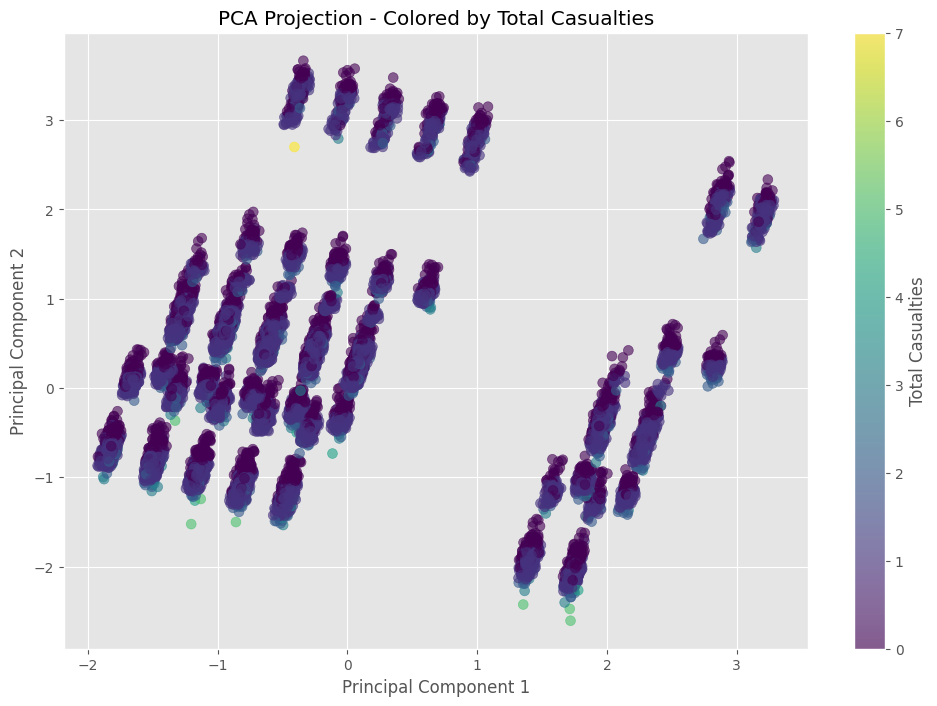

In [13]:
# Apply preprocessing to the entire dataset
X_scaled = preprocessor.fit_transform(X)

# Apply PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled.toarray() if scipy.sparse.issparse(X_scaled) else X_scaled)

# Create DataFrame for visualization
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    target: df_clean[target].values
})

# Plot PCA results colored by total casualties
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], 
                     c=pca_df[target], cmap='viridis', alpha=0.6, s=50)
plt.title('PCA Projection - Colored by Total Casualties')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Total Casualties')
plt.show()

In [14]:
X_for_clustering = X_scaled.toarray() if scipy.sparse.issparse(X_scaled) else X_scaled

# Find optimal number of clusters
silhouette_scores = []
inertia_values = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_for_clustering)
    silhouette_avg = silhouette_score(X_for_clustering, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertia_values.append(kmeans.inertia_)
    print(f"For n_clusters = {k}, silhouette score: {silhouette_avg:.3f}")

# Choose optimal k and apply K-Means
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_for_clustering)
pca_df['KMeans_Cluster'] = kmeans_labels

For n_clusters = 2, silhouette score: 0.167
For n_clusters = 3, silhouette score: 0.169
For n_clusters = 4, silhouette score: 0.130
For n_clusters = 5, silhouette score: 0.138
For n_clusters = 6, silhouette score: 0.145
For n_clusters = 7, silhouette score: 0.119
For n_clusters = 8, silhouette score: 0.116
For n_clusters = 9, silhouette score: 0.120
For n_clusters = 10, silhouette score: 0.116


In [15]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_for_clustering)
pca_df['DBSCAN_Cluster'] = dbscan_labels

# Calculate clustering metrics
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}% of data)")

Number of clusters: 0
Number of noise points: 15226 (100.00% of data)


In [16]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_for_clustering)
pca_df['Hierarchical_Cluster'] = hierarchical_labels

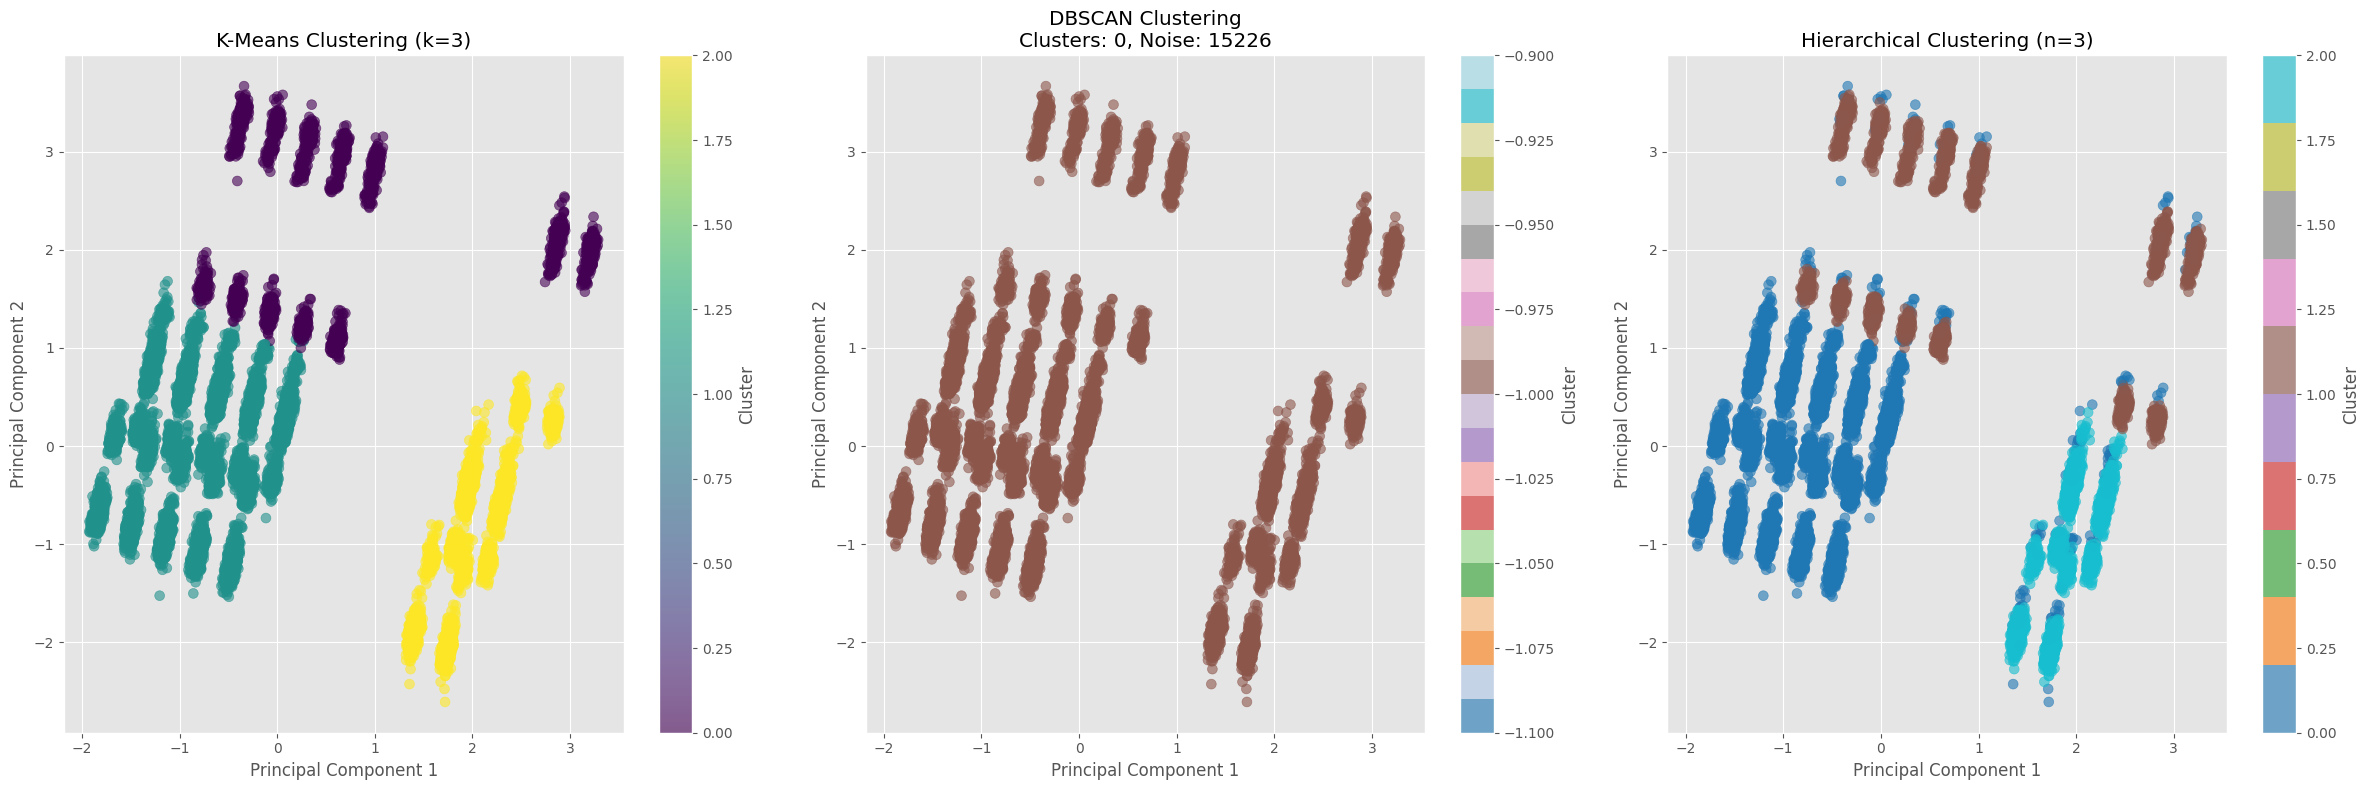

In [17]:
# Compare clustering results
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot K-Means results
scatter1 = axes[0].scatter(pca_df['PCA1'], pca_df['PCA2'], 
                          c=pca_df['KMeans_Cluster'], cmap='viridis', alpha=0.6, s=50)
axes[0].set_title(f'K-Means Clustering (k={optimal_k})')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot DBSCAN results
scatter2 = axes[1].scatter(pca_df['PCA1'], pca_df['PCA2'], 
                          c=pca_df['DBSCAN_Cluster'], cmap='tab20', alpha=0.6, s=50)
axes[1].set_title(f'DBSCAN Clustering\nClusters: {n_clusters}, Noise: {n_noise}')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# Plot Hierarchical results
scatter3 = axes[2].scatter(pca_df['PCA1'], pca_df['PCA2'], 
                          c=pca_df['Hierarchical_Cluster'], cmap='tab10', alpha=0.6, s=50)
axes[2].set_title(f'Hierarchical Clustering (n={optimal_k})')
axes[2].set_xlabel('Principal Component 1')
axes[2].set_ylabel('Principal Component 2')
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

In [18]:
# Analyze clusters
df_clean.loc[:, 'KMeans_Cluster'] = kmeans_labels
df_clean.loc[:, 'DBSCAN_Cluster'] = dbscan_labels
df_clean.loc[:, 'Hierarchical_Cluster'] = hierarchical_labels

# Function to calculate cluster statistics
def get_cluster_stats(df, cluster_col):
    return df.groupby(cluster_col).agg({
        target: ['mean', 'count'],
        'IsRushHour': 'mean',
        'IsWeekend': 'mean',
        'IsNightTime': 'mean'
    })

# Print statistics for each clustering method
print("\nK-Means Cluster Statistics:")
print(get_cluster_stats(df_clean, 'KMeans_Cluster'))

print("\nDBSCAN Cluster Statistics:")
print(get_cluster_stats(df_clean, 'DBSCAN_Cluster'))

print("\nHierarchical Cluster Statistics:")
print(get_cluster_stats(df_clean, 'Hierarchical_Cluster'))


K-Means Cluster Statistics:
               Total_Casualties       IsRushHour IsWeekend IsNightTime
                           mean count       mean      mean        mean
KMeans_Cluster                                                        
0                      0.831887  2189   0.000000  0.228415    1.000000
1                      0.814273  9767   0.484591  0.000000    0.000000
2                      0.817737  3270   0.395719  1.000000    0.099388

DBSCAN Cluster Statistics:
               Total_Casualties        IsRushHour IsWeekend IsNightTime
                           mean  count       mean      mean        mean
DBSCAN_Cluster                                                         
-1                     0.817549  15226   0.395836  0.247603    0.165112

Hierarchical Cluster Statistics:
                     Total_Casualties        IsRushHour IsWeekend IsNightTime
                                 mean  count       mean      mean        mean
Hierarchical_Cluster                   